In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import argparse
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
import copy

import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Working through [this repo](https://github.com/peisuke/MomentumContrast.pytorch/blob/master/network.py) to learn how MoCo works and get around to coding my own version of it for specific project tasks.

This repo uses a very small, very simple neural network to make unsupervised representations of mnist digits. 

Here is the network. It inherits from `nn.Module` and has a method `forward` that takes input `x` and runs it through the network. **Remember this for when we're using a drop-in replacement like ResNet.**

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # in channels, out channels, kernel size, stride
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128) # at this point, image is 12 x 12, so 12 x 12 x 64 = 9216
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.normalize(x) # normalize vector length, from paper!!!
        return x

Here are some functions and their explanations.

This is a class that takes in a set of transformations when initialized. It is passed a single image when called and returns **two** copies of the image that have been transformed.

Questions: 

1. What is img type? Pillow image?
2. Are the transformations applied to the copies exactly the same? Or stochastic?

In [3]:
class DuplicatedCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms
        
    def __call__(self, img):
        img1 = img.copy()
        img2 = img.copy()
        for t in self.transforms:
            img1 = t(img1)
            img2 = t(img2)
        return img1, img2

The paper's signature momentum update. The query encoder learns, but the key encoder only receives a momentum update from the query encoder.

Iterate through the named paramaters in `param_q`. If in `param_k`, then use the momentum update to update k's parameters with q's.

Questions:

1. Difference between `state_dict` and `named_parameters`.
2. Use of last line `load_state_dict`. 

In [4]:
def momentum_update(model_q, model_k, beta=0.999):
    param_k = model_k.state_dict()
    param_q = model_q.named_parameters()
    for n, q in param_q:
        if n in param_k:
            param_k[n].data.copy_(beta*param_k[n].data + (1-beta)*q.data)
    model_k.load_state_dict(param_k)

Function for adding data to key queue.

In [5]:
def queue_data(data, k):
    return torch.cat([data, k], dim=0)

Function for removing oldest keys from key queue.

In [6]:
def dequeue_data(data, K=4096):
    if len(data) > K:
        return data[-K:]
    else:
        return data

Function for initializing the queue in the first place. Put the queue on the GPU.

Questions:

1. What is detach?
    * Detaches a tensor from the tensor graph. 

In [7]:
def initialize_queue(model_k, device, train_loader):
    queue = torch.zeros((0, 128), dtype=torch.float)
    queue = queue.to(device)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        x_k = data[1] # keys are the second in the train loader
        x_k = x_k.to(device)
        k = model_k(x_k)
        k = k.detach()
        queue = queue_data(queue, k)
        queue = dequeue_data(queue, K = 10)
        break
    return queue

Function for training the model.

Questions:

1. What is `model_q.train()`?
    * Lets the model know it's being trained, for things like dropout that act differently during train and eval.

In [8]:
def train(model_q, model_k, device, train_loader, queue, optimizer, epoch, temp=0.07):
    model_q.train()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        x_q = data[0]
        x_k = data[1]
        
        x_q, x_k = x_q.to(device), x_k.to(device)
        q = model_q(x_q)
        k = model_k(x_k)
        k = k.detach()
        
        N = data[0].shape[0] # batch size
        K = queue.shape[0] # queue size
        # batch matrix mul for pos, so it's only dot produced with its key
        l_pos = torch.bmm(q.view(N,1,-1), k.view(N,-1,1))
        # normal matrix mul for neg - every query dotted with every key in queue
        l_neg = torch.mm(q.view(N,-1), queue.T.view(-1,K))
        
        logits = torch.cat([l_pos.view(N, 1), l_neg], dim=1)
        
        # "true" answer is 0, first item in logits
        labels = torch.zeros(N, dtype=torch.long)
        labels = labels.to(device)
        
        cross_entropy_loss = nn.CrossEntropyLoss()
        loss = cross_entropy_loss(logits/temp, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        momentum_update(model_q, model_k)
        
        queue = queue_data(queue, k)
        queue = dequeue_data(queue)
    
    total_loss /= len(train_loader.dataset)
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, total_loss))       

Everything should be in place. Now to train.

In [9]:
batchsize = 100
epochs = 50
out_dir = "result"

device = torch.device("cuda")

In [10]:
kwargs = {'num_workers': 4, 'pin_memory': True}

In [11]:
transform = DuplicatedCompose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1), ratio=(0.9, 1.1), interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [12]:
train_mnist = datasets.MNIST("./", train=True, download=True, transform=transform)
test_mnist = datasets.MNIST("./", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_mnist, batch_size=batchsize, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_mnist, batch_size=batchsize, shuffle=True, **kwargs)

In [13]:
model_q = Net().to(device)
model_k = copy.deepcopy(model_q)

In [15]:
from torchsummary import summary

ModuleNotFoundError: No module named 'torchsummary'

In [14]:
optimizer = optim.SGD(model_q.parameters(), lr=0.01, weight_decay=0.0001)

In [15]:
queue = initialize_queue(model_k, device, train_loader)

In [16]:
for epoch in range(1, epochs+1):
    train(model_q, model_k, device, train_loader, queue, optimizer, epoch)

Train Epoch: 1 	Loss: 0.037002
Train Epoch: 2 	Loss: 0.028533
Train Epoch: 3 	Loss: 0.024091
Train Epoch: 4 	Loss: 0.020667
Train Epoch: 5 	Loss: 0.018227
Train Epoch: 6 	Loss: 0.016425
Train Epoch: 7 	Loss: 0.015045
Train Epoch: 8 	Loss: 0.014132
Train Epoch: 9 	Loss: 0.013175
Train Epoch: 10 	Loss: 0.012605
Train Epoch: 11 	Loss: 0.012083
Train Epoch: 12 	Loss: 0.011634
Train Epoch: 13 	Loss: 0.011249
Train Epoch: 14 	Loss: 0.010814
Train Epoch: 15 	Loss: 0.010591
Train Epoch: 16 	Loss: 0.010208
Train Epoch: 17 	Loss: 0.009966
Train Epoch: 18 	Loss: 0.009794
Train Epoch: 19 	Loss: 0.009499
Train Epoch: 20 	Loss: 0.009311
Train Epoch: 21 	Loss: 0.009059
Train Epoch: 22 	Loss: 0.008913
Train Epoch: 23 	Loss: 0.008723
Train Epoch: 24 	Loss: 0.008561
Train Epoch: 25 	Loss: 0.008434
Train Epoch: 26 	Loss: 0.008341
Train Epoch: 27 	Loss: 0.008145
Train Epoch: 28 	Loss: 0.008054
Train Epoch: 29 	Loss: 0.007897
Train Epoch: 30 	Loss: 0.007752
Train Epoch: 31 	Loss: 0.007668
Train Epoch: 32 	

In [19]:
os.makedirs(out_dir, exist_ok=True)
torch.save(model_q.state_dict(), os.path.join(out_dir, 'model.pth'))

Training is done. Visualize the results.

In [18]:
def show(mnist, targets, ret):
    target_ids = range(len(set(targets)))
    
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'violet', 'orange', 'purple']
    
    plt.figure(figsize=(12, 10))
    
    ax = plt.subplot(aspect='equal')
    for label in set(targets):
        idx = np.where(np.array(targets) == label)[0]
        plt.scatter(ret[idx, 0], ret[idx, 1], c=colors[label], label=label)
    
    for i in range(0, len(targets), 250):
        img = (mnist[i][0] * 0.3081 + 0.1307).numpy()[0]
        img = OffsetImage(img, cmap=plt.cm.gray_r, zoom=0.5) 
        ax.add_artist(AnnotationBbox(img, ret[i]))
    
    plt.legend()
    plt.show()

100%|██████████| 10000/10000 [00:07<00:00, 1332.94it/s]


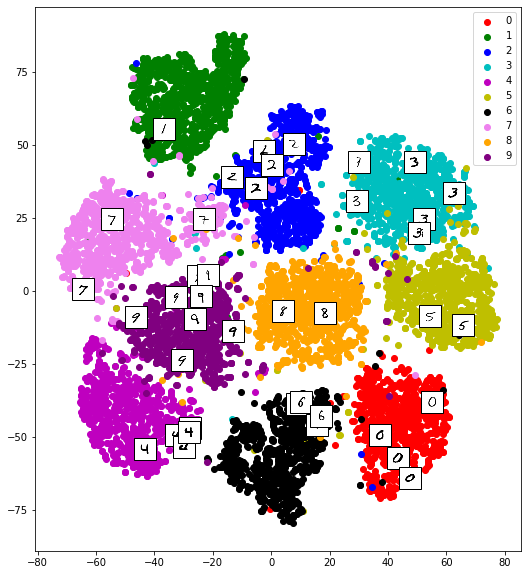

In [20]:
model_path = 'result/model.pth'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

mnist = datasets.MNIST('./', train=False, download=True, transform=transform)

model = Net()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

data = []
targets = []
for m in tqdm.tqdm(mnist):
    target = m[1]
    targets.append(target)
    x = m[0]
    x = x.view(1, *x.shape)
    feat = model(x)
    data.append(feat.data.numpy()[0])

ret = TSNE(n_components=2, random_state=0).fit_transform(data)

show(mnist, targets, ret)